## Import Packages

In [872]:
import math
import numpy as np
import pandas as pd
from typing import Dict, List

# Not sure if these are available
import copy
import collections 
from collections import defaultdict
import random

# Not available in the competition but necessary for our current moment
from pathlib import Path
from decouple import config
import matplotlib.pyplot as plt
import seaborn as sns

#from datamodel import OrderDepth, TradingState, Order

### Implement this with 2024 code to keep track of positions

In [873]:
# Default positions - before the Trader class initiates 
empty_dict = {'AMETHYSTS' : 0, 'STARFRUIT' : 0} 

def def_value():
    return copy.deepcopy(empty_dict)

INF = int(1e9)


### Read Data

In [874]:
## Specify file paths for quotes and trades
BASE_DIR = Path("./data-2023")
DATA_DIR = config('DATA_DIR', default=(BASE_DIR / 'island-data-bottle-round-3'), cast=Path)

quotes = pd.read_csv(DATA_DIR / "prices_round_3_day_0.csv")
quote_columns = quotes.columns[0].split(';')
quotes = quotes[quotes.columns[0]].str.split(';', expand=True)
quotes.columns = quote_columns

trades = pd.read_csv(DATA_DIR / "trades_round_3_day_0_nn.csv")
trades_columns = trades.columns[0].split(';')
trades = trades[trades.columns[0]].str.split(';', expand=True)
trades.columns = trades_columns

print(f'Quote Shape: {quotes.shape}')
print(f'Trades Shape: {trades.shape}')

Quote Shape: (70000, 17)
Trades Shape: (7083, 7)


## Data Engineering

### Drop unused columns - specific to this test set

In [875]:
quotes.drop(columns = ['day', 'profit_and_loss'], inplace=True)
trades.drop(columns = ['buyer', 'seller'], inplace=True)

### All the values are string - convert them to floats

In [876]:
quotes_num_cols = ['timestamp', 'bid_price_1', 'ask_price_1', 'bid_price_2', 'ask_price_2', 'bid_price_3', 'ask_price_3', \
                   'bid_volume_1', 'ask_volume_1', 'bid_volume_2', 'ask_volume_2', 'bid_volume_3', 'ask_volume_3', 'mid_price']
trades_num_cols = ['timestamp', 'price', 'quantity']

quotes[quotes_num_cols] = quotes[quotes_num_cols].replace('', '0').astype(float)
trades[trades_num_cols] = trades[trades_num_cols].replace('', '0').astype(float)

## Divide timestamp by 100, otherwise skip this

divisor = 100
quotes['timestamp'] = quotes['timestamp']/divisor
trades['timestamp'] = trades['timestamp']/divisor

### Create multi-index for Product and Timestamp

In [877]:
quotes = quotes.sort_values(by = ['product','timestamp'])
quotes.set_index(['product', 'timestamp'], inplace=True)

trades = trades.sort_values(by = ['symbol','timestamp'])
trades.set_index(['symbol', 'timestamp'], inplace=True)

quotes_products = list(quotes.index.get_level_values(level=0).unique())
trades_symbols = list(trades.index.get_level_values(level=0).unique())


print(f'Quotes levels: {quotes_products}')
print(f'Trades levels: {trades_symbols}')

Quotes levels: ['BANANAS', 'BERRIES', 'COCONUTS', 'DIVING_GEAR', 'DOLPHIN_SIGHTINGS', 'PEARLS', 'PINA_COLADAS']
Trades levels: ['BANANAS', 'BERRIES', 'COCONUTS', 'DIVING_GEAR', 'PEARLS', 'PINA_COLADAS']


In [878]:
# Check a product as an example in trades
quotes.loc['PINA_COLADAS']

,bid_price_1,bid_volume_1,bid_price_2,bid_volume_2,bid_price_3,bid_volume_3,ask_price_1,ask_volume_1,ask_price_2,ask_volume_2,ask_price_3,ask_volume_3,mid_price
timestamp,,,,,,,,,,,,,
0.0,15225.0,82.0,0.0,0.0,0.0,0.0,15228.0,82.0,0.0,0.0,0.0,0.0,15226.5
1.0,15223.0,109.0,0.0,0.0,0.0,0.0,15226.0,109.0,0.0,0.0,0.0,0.0,15224.5
2.0,15226.0,7.0,15224.0,101.0,0.0,0.0,15227.0,101.0,0.0,0.0,0.0,0.0,15226.5
3.0,15224.0,84.0,0.0,0.0,0.0,0.0,15227.0,84.0,0.0,0.0,0.0,0.0,15225.5
4.0,15220.0,105.0,0.0,0.0,0.0,0.0,15223.0,105.0,0.0,0.0,0.0,0.0,15221.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995.0,15004.0,95.0,0.0,0.0,0.0,0.0,15007.0,95.0,0.0,0.0,0.0,0.0,15005.5
9996.0,15002.0,107.0,0.0,0.0,0.0,0.0,15005.0,107.0,0.0,0.0,0.0,0.0,15003.5
9997.0,15003.0,77.0,0.0,0.0,0.0,0.0,15006.0,77.0,0.0,0.0,0.0,0.0,15004.5


In [879]:
# Check a product as an example in trades
trades.loc['PINA_COLADAS']

,currency,price,quantity
timestamp,,,
112.0,SEASHELLS,15174.0,8.0
120.0,SEASHELLS,15171.0,27.0
120.0,SEASHELLS,15171.0,11.0
155.0,SEASHELLS,15163.0,3.0
196.0,SEASHELLS,15178.0,11.0
...,...,...,...
9599.0,SEASHELLS,15005.0,3.0
9610.0,SEASHELLS,15006.0,4.0
9820.0,SEASHELLS,14962.0,3.0


### Calculate Percentage return on the tick data 

In [880]:
# Calculate percentage returns of the tick data
grouped = quotes.groupby(level=0)

# Calculate percentage changes for the 'mid_price' column within each group
quotes['rets'] = grouped['mid_price'].pct_change()

# Fill NaN values resulting from percentage change calculation
quotes['rets'].fillna(0, inplace=True)  # Or any other method to handle NaN values

In [881]:
quotes.loc['BANANAS']['rets']

timestamp
0.0       0.000000
1.0      -0.000408
2.0       0.000306
3.0       0.000102
4.0       0.000102
            ...   
9995.0   -0.000308
9996.0   -0.000205
9997.0    0.001232
9998.0   -0.000615
9999.0    0.000103
Name: rets, Length: 10000, dtype: float64

### Group by the duplicate timestamps in trades by summing the quantity and averaging the price

In [882]:
# Group by the multi-index (assuming product is the first level) and keep the currency
trades = trades.groupby(level= ['symbol', 'timestamp']).agg({'currency': 'first', 'quantity':'sum', 'price':'mean'})

if len(trades.index.unique()) == len(trades):
    print('Trade have unique index')

Trade have unique index


### Buy and Sells are mapped from the quotes to the trades data. Buys have positive, Sells have negative quantity

In [883]:
# Create a new dataframe with only necessary columns
best_quotes = quotes[['bid_price_1', 'ask_price_1']]

# Change the name of the indices so that join does not produce new indices
best_quotes.rename_axis(['symbol', 'timestamp'], inplace=True)
trades = trades.join(best_quotes)

# Define quantity_adj as the quantity with buys/sell
trades['quantity_adj'] = trades['quantity']
trades.loc[trades['price'] == trades['ask_price_1'], 'quantity_adj'] *= -1

# Check for null values
quantity_adj_null = trades['quantity_adj'].isna().sum()
print(f'Number of null values in adjusted quantity for buy and sells: {quantity_adj_null}')

Number of null values in adjusted quantity for buy and sells: 0


### Plot the bid-ask spread
Use mean spread to decide on the minimum edge for each product

BANANAS: mean spread = -5.2627
BANANAS: median spread = -5.2627


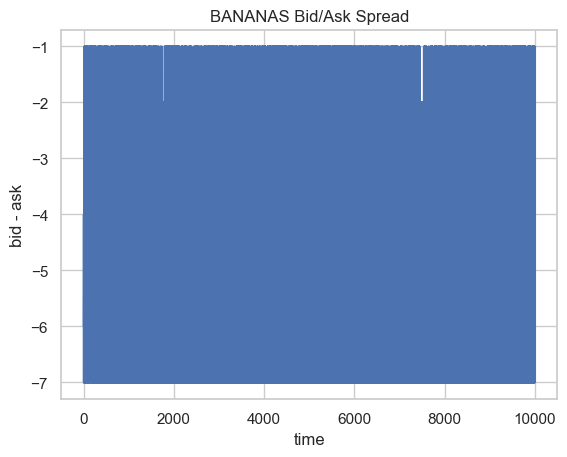

BERRIES: mean spread = -6.5587
BERRIES: median spread = -6.5587


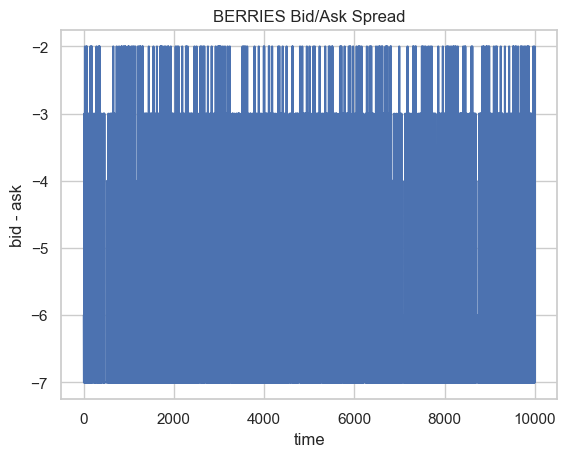

COCONUTS: mean spread = -2.4787
COCONUTS: median spread = -2.4787


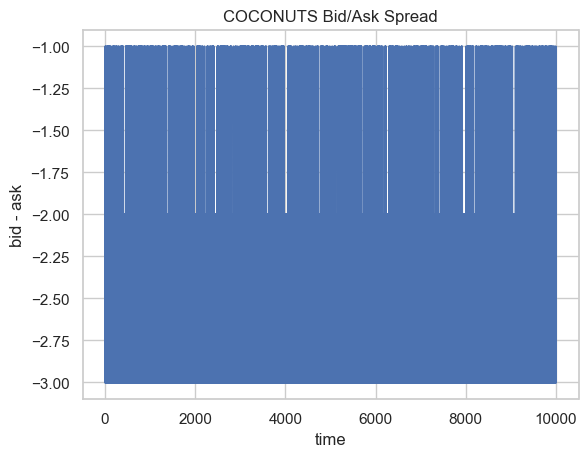

DIVING_GEAR: mean spread = -2.47
DIVING_GEAR: median spread = -2.47


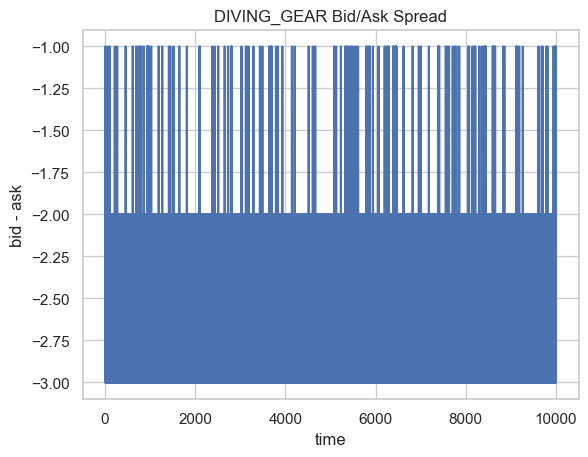

DOLPHIN_SIGHTINGS: mean spread = 0.0
DOLPHIN_SIGHTINGS: median spread = 0.0


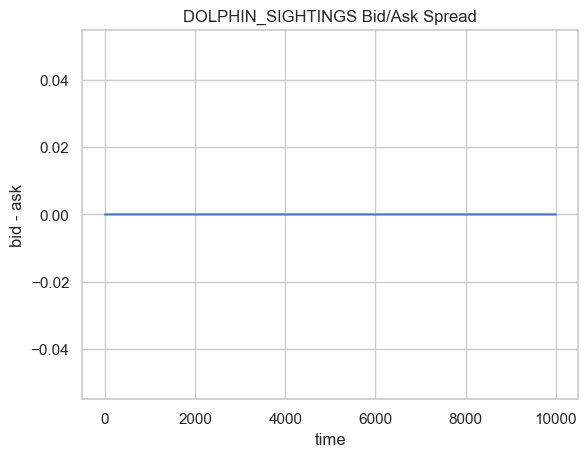

PEARLS: mean spread = -6.7767
PEARLS: median spread = -6.7767


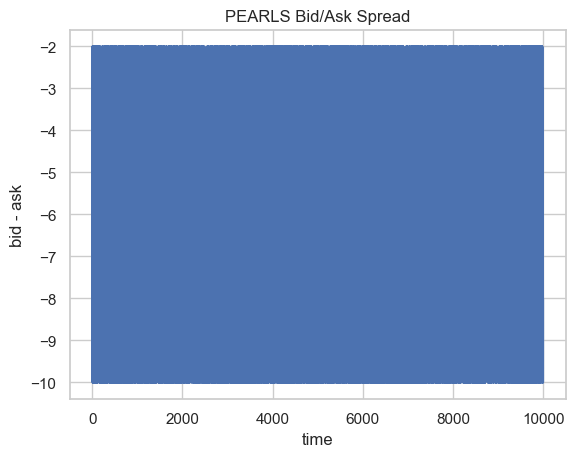

PINA_COLADAS: mean spread = -2.6655
PINA_COLADAS: median spread = -2.6655


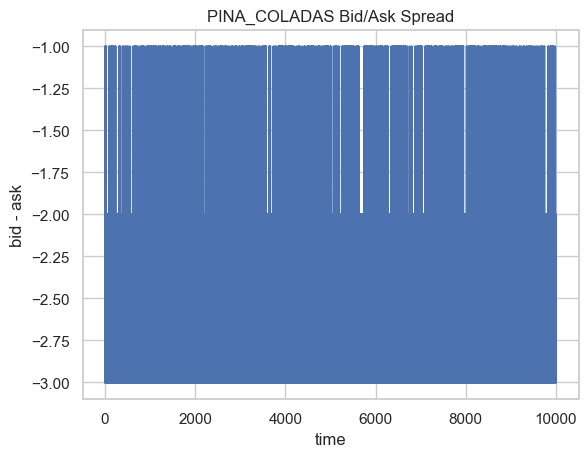

In [884]:
for x in quotes_products:
    # Create the plot
    spread = quotes.loc[x]['bid_price_1'] - quotes.loc[x]['ask_price_1']

    spread_mean = spread.mean()
    spread_median = spread.mean()

    plt.plot(quotes.loc[x].index, spread)

    # Title and labels
    plt.title(f'{x} Bid/Ask Spread')
    plt.xlabel('time')
    plt.ylabel('bid - ask')

    print(f'{x}: mean spread = {spread_mean}')
    print(f'{x}: median spread = {spread_median}')
    # Display the plot
    plt.show()

### Plot the price graphs
Check the trends

BANANAS volatility = 33.751


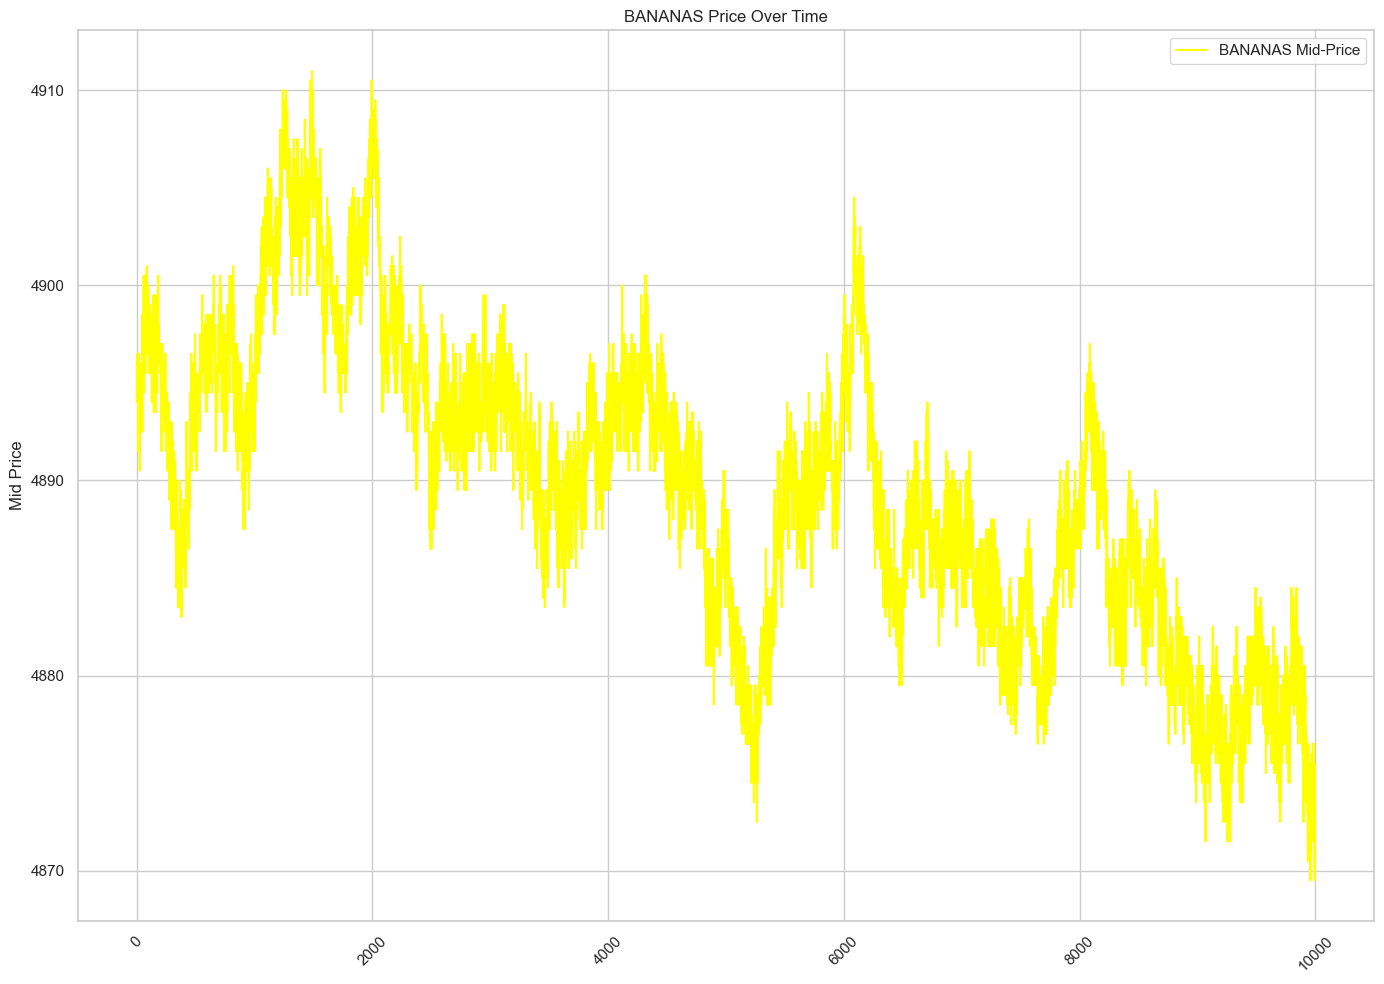

BERRIES volatility = 27.015


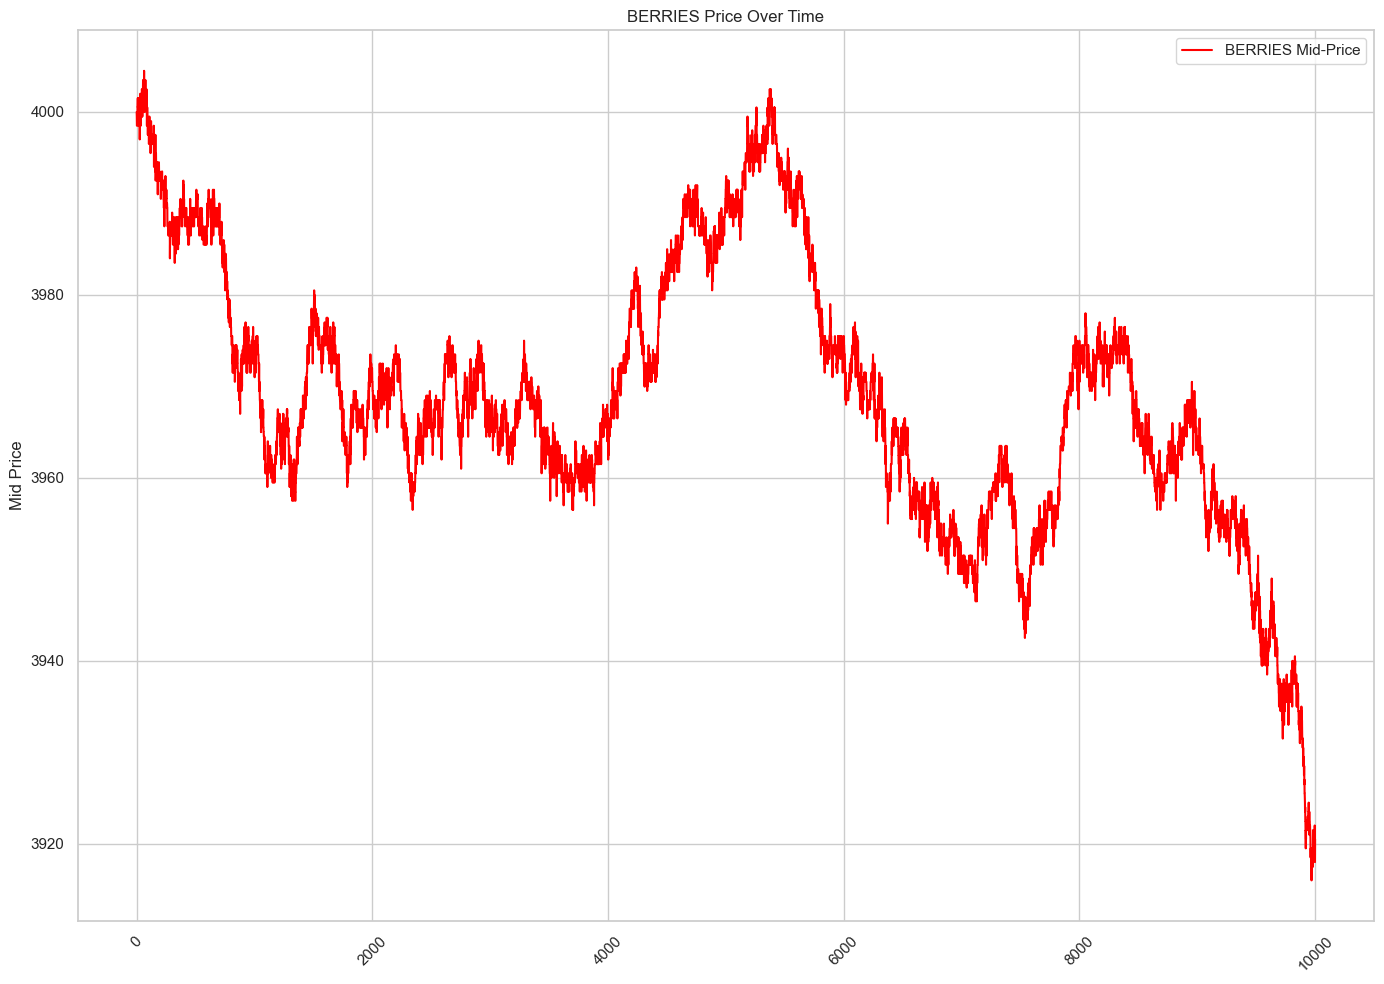

COCONUTS volatility = 11.138


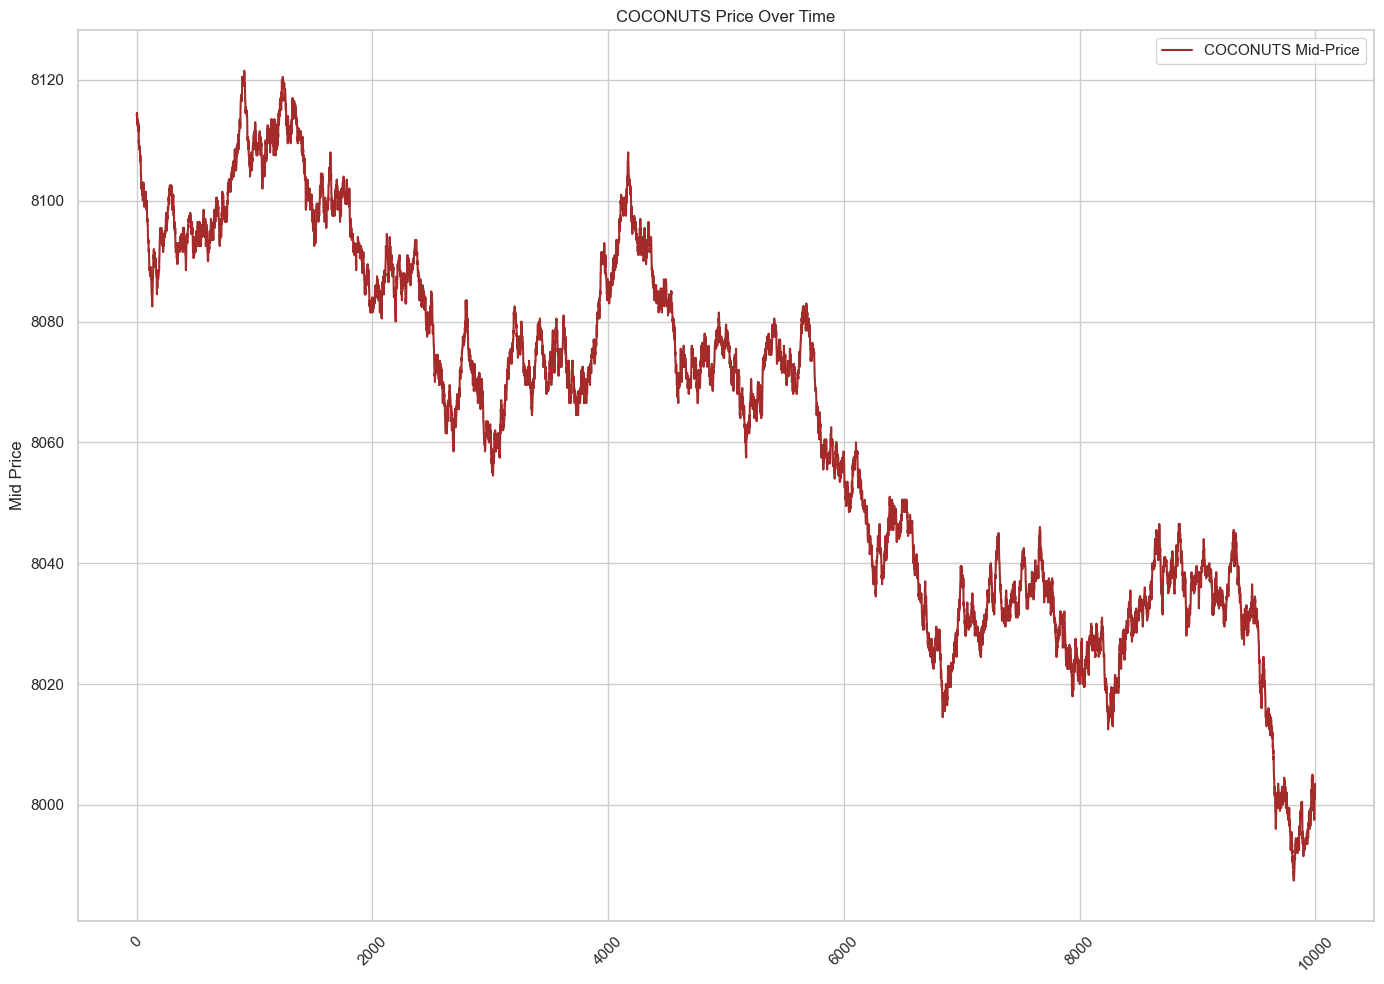

DIVING_GEAR volatility = 6.281


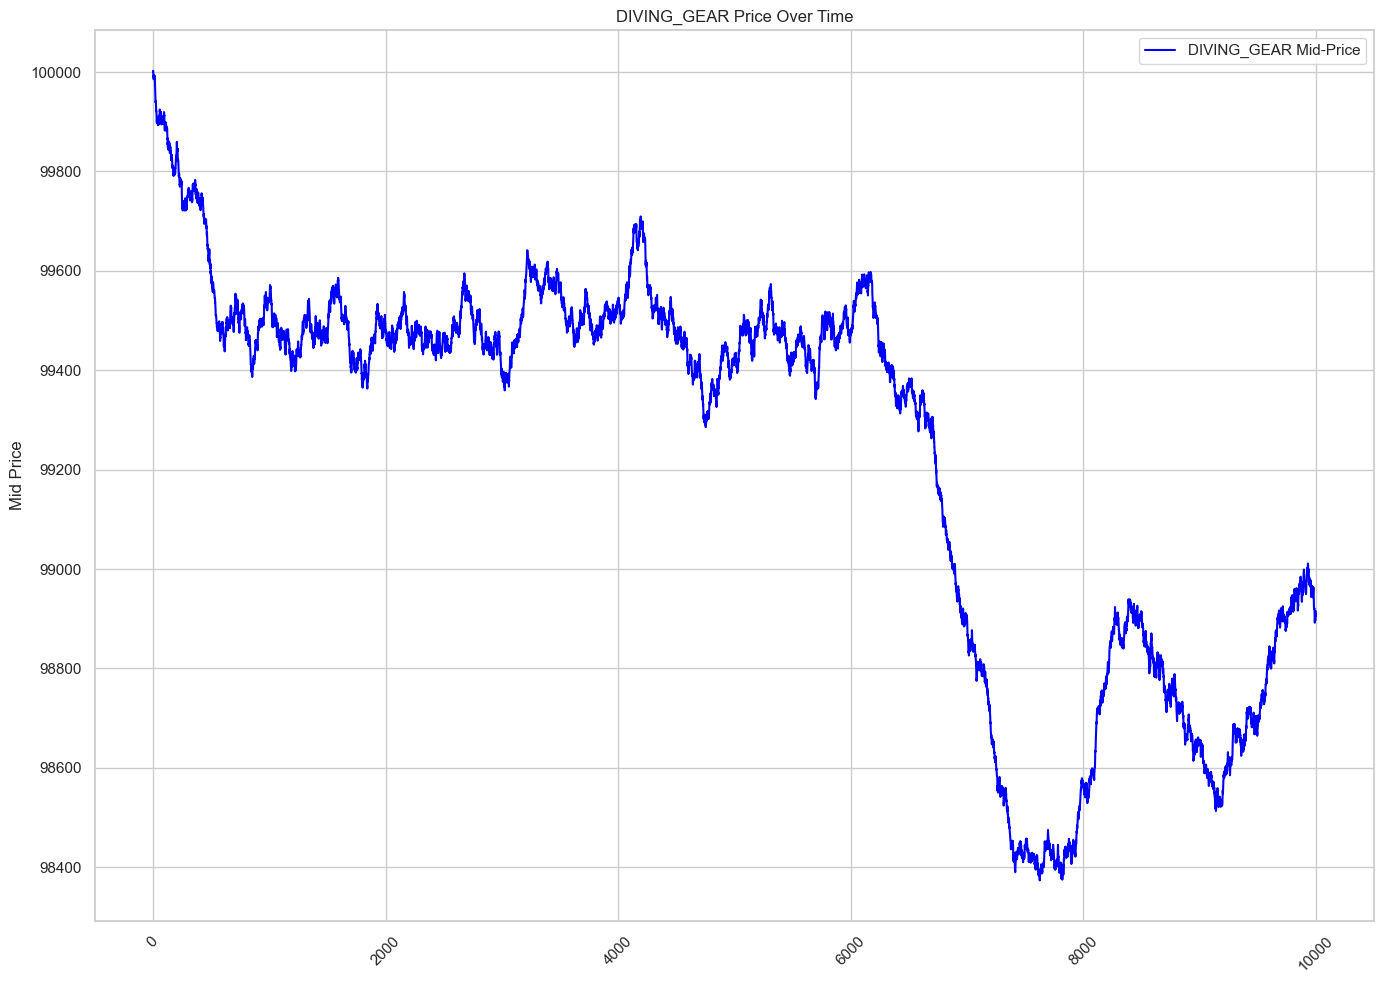

DOLPHIN_SIGHTINGS volatility = 17.208


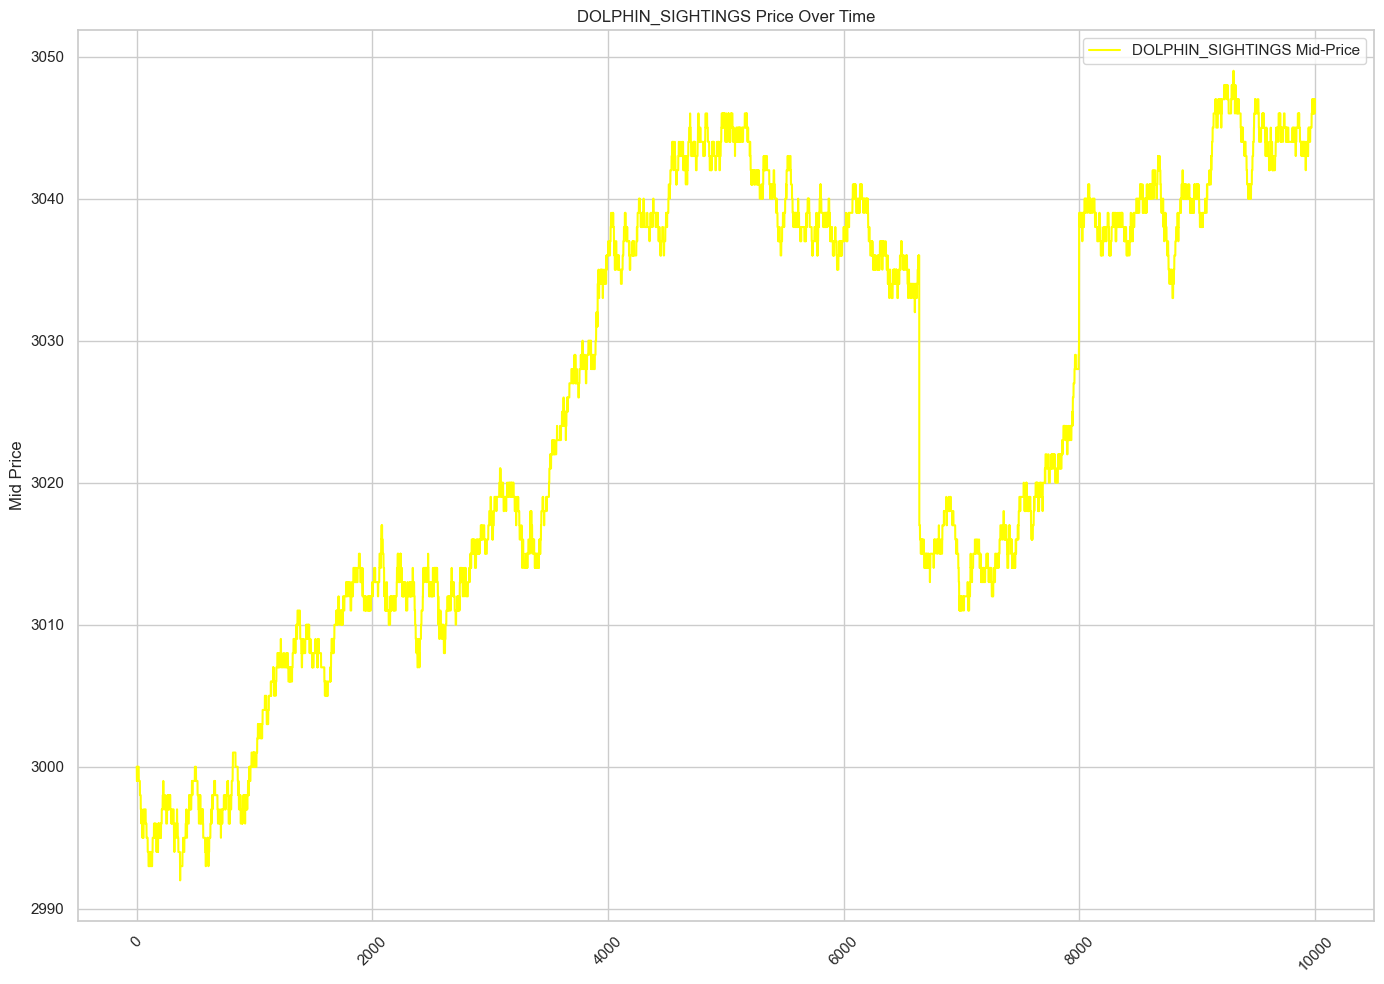

PEARLS volatility = 21.241


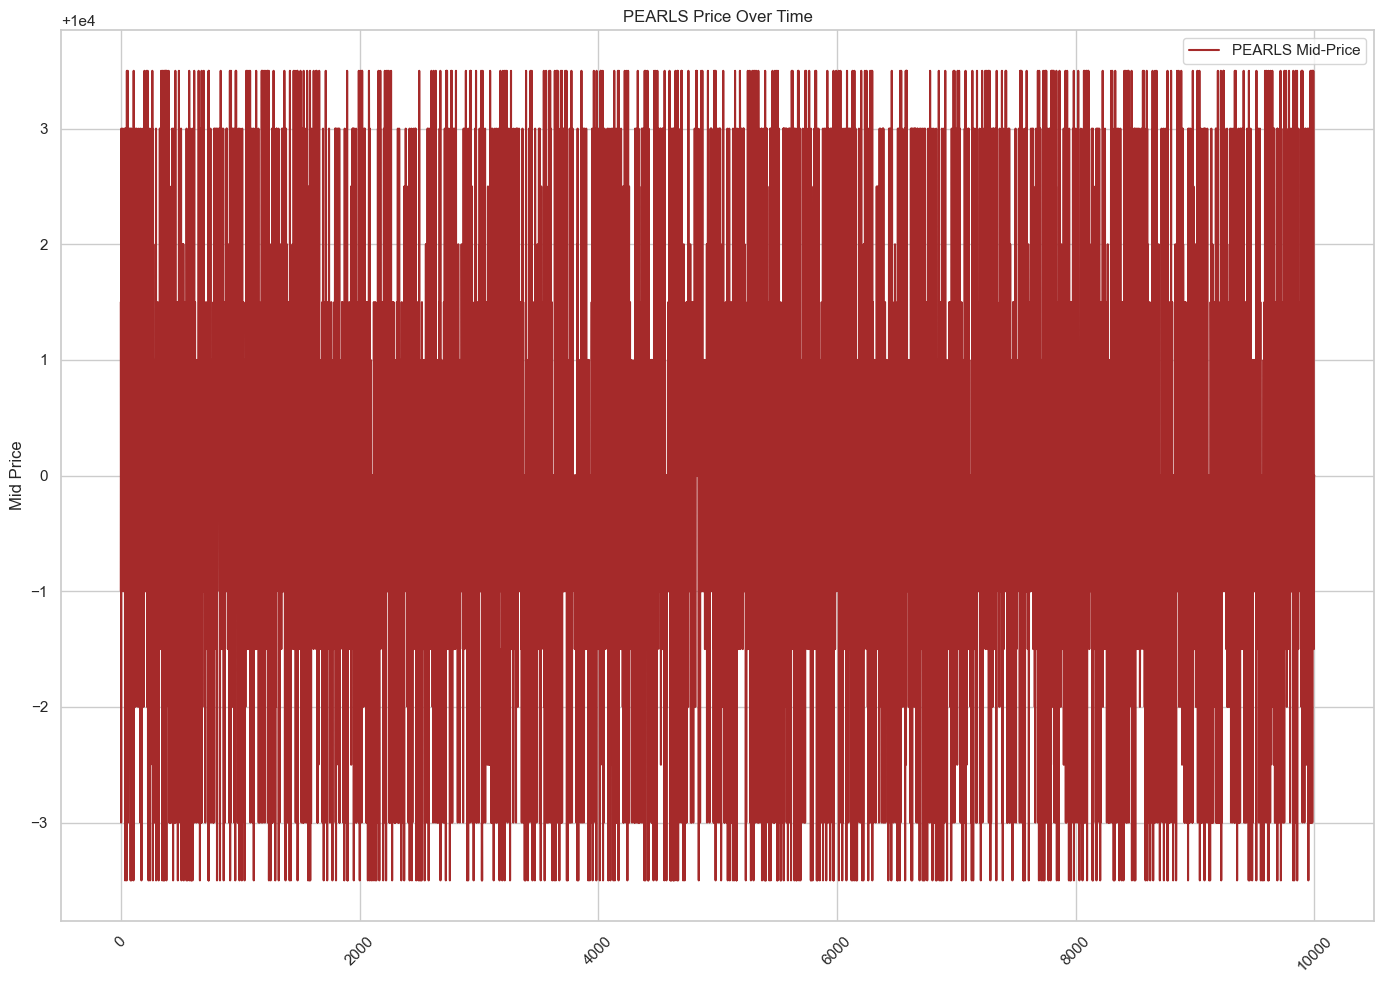

PINA_COLADAS volatility = 14.243


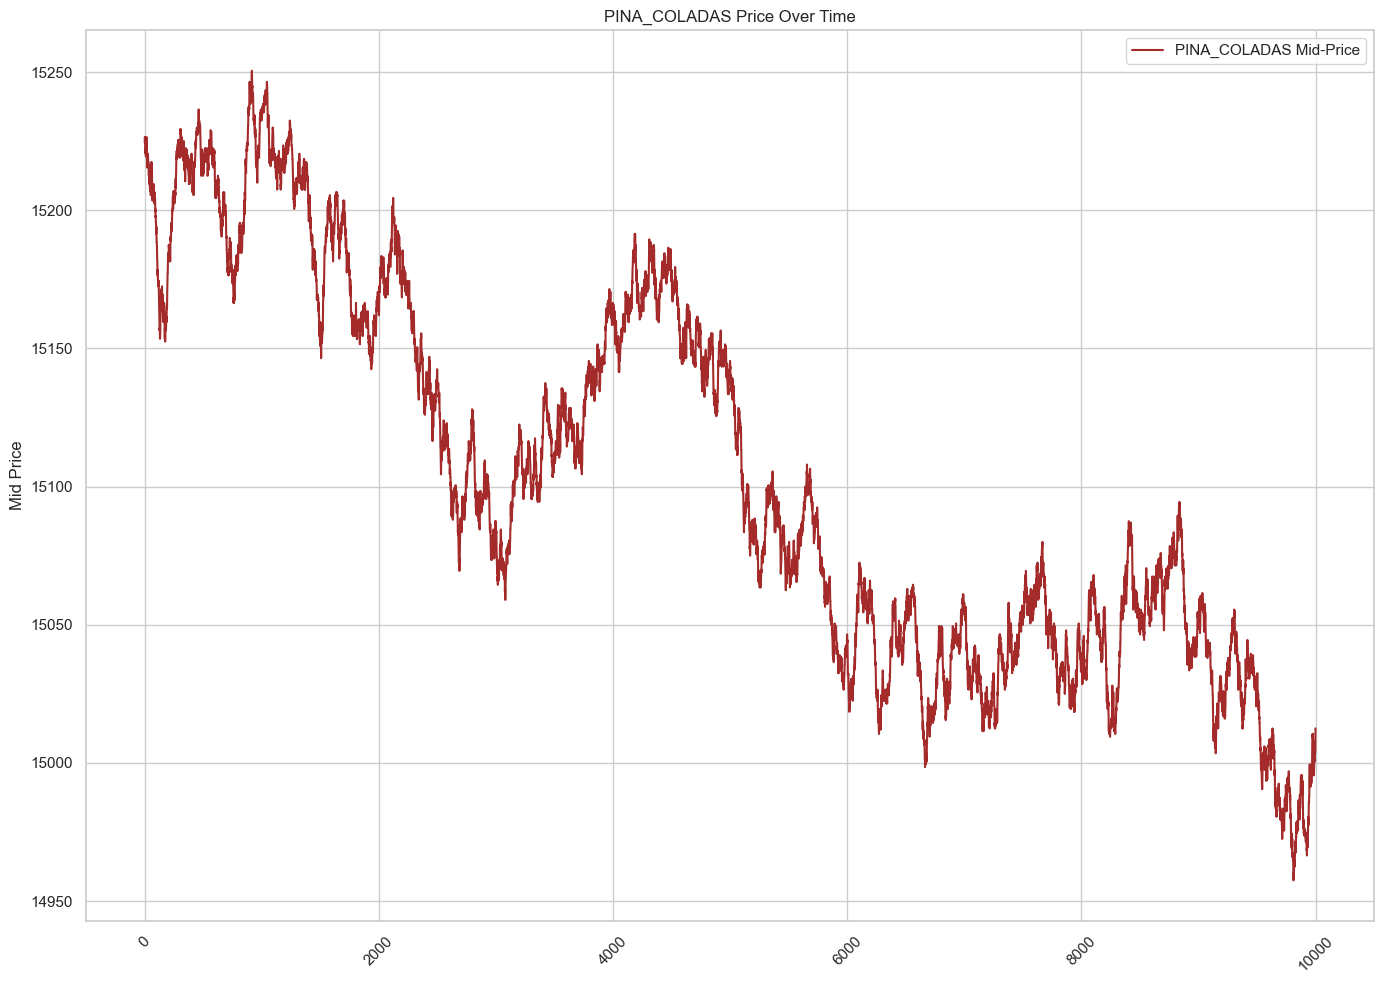

In [885]:
for x in quotes_products:
    # Set the Seaborn theme for better aesthetics
    sns.set_theme(style="whitegrid")

    # Colors for the plots
    colors = {
        'BANANAS': 'yellow',
        'BERRIES': 'red',
        'COCONUTS': 'brown',
        'DIVING_GEAR': 'blue',
        'DOLPHIN_SIGHTINGS': 'yellow',
        'PEARLS': 'brown',
        'PINA_COLADAS': 'brown',
    }

    rets_vol = quotes.loc[x, 'rets'].std() * 10e4
    print(f'{x} volatility = {round(rets_vol,3)}')

    # Plotting ETH/USD Mid Price
    plt.figure(figsize=(14, 10))  # Create a new figure for ETH/USD
    plt.plot(quotes.loc[x].index, quotes.loc[x]['mid_price'], label= f'{x} Mid-Price', color=colors[f'{x}'])
    plt.title(f'{x} Price Over Time')
    plt.ylabel('Mid Price')
    plt.legend()
    plt.xticks(rotation=45)
    #plt.yticks(range(int(min(quotes.loc[x]['mid_price'])), int(max(quotes.loc[x]['mid_price'])) + 1, 10))
    plt.tight_layout()
    plt.show()

### Check the correlation across products

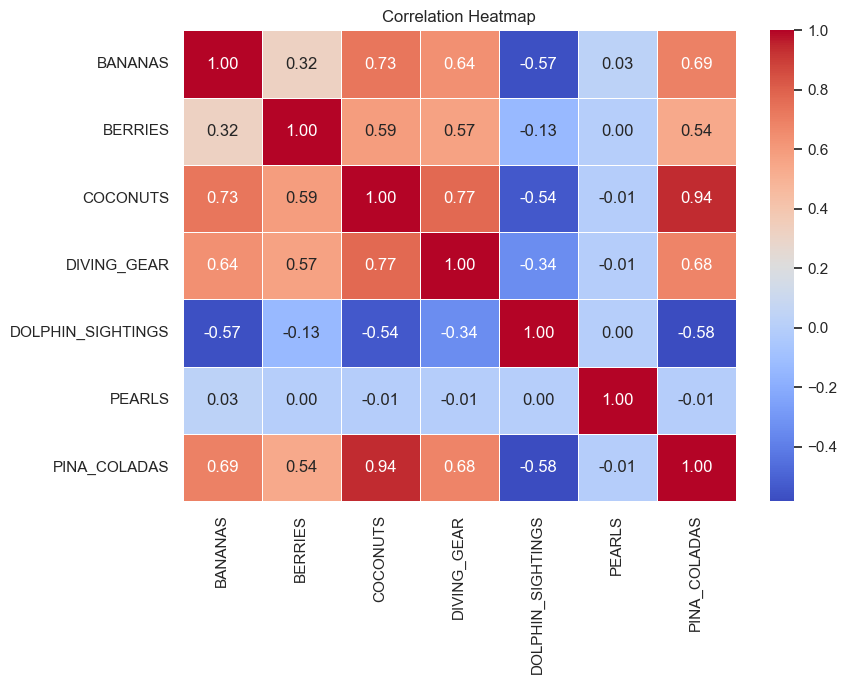

In [886]:
series = pd.DataFrame(columns = quotes_products)
 
for x in quotes_products:
    series[x] = quotes.loc[x]['mid_price']

# Calculate correlation
correlation_matrix = series.corr()

# Plotting the heatmap
plt.figure(figsize=(9, 7))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')

# Adjusting aspect ratio to ensure all elements are properly displayed
plt.tight_layout()

plt.show()

## Calculate MKT Theo with last's data - MKT Theo is very close to the midprice FYI

In [887]:
def objective_function(x, bids, asks, tick_size = 0.5):
    
    # Calculate the sum of contributions from all bid and ask levels
    total = sum(volume * math.exp((price - x) / tick_size) for price, volume in bids) + \
            sum(volume * math.exp((x - price) / tick_size) for price, volume in asks)
    
    return total

# Needed if the Newton-Raphson approximation method is used
#def derivative_objective_function(x, bids, asks, tick_size = 1.0):
#    
    # Calculate the derivative of the objective function
#    derivative = sum(-volume * math.exp((price - x) / tick_size) / tick_size for price, volume in bids) + \
#                 sum(volume * math.exp((x - price) / tick_size) / tick_size for price, volume in asks)
    
#    return derivative

def gradient_descent(x_guess, bids, asks, tick_size=1.0, learning_rate=0.01, tolerance=1.0, max_iterations=1000):
    for i in range(max_iterations):
        gradient = 0
        for price, volume in bids:
            gradient += -volume * math.exp((price - x_guess) / tick_size) / tick_size
        for price, volume in asks:
            gradient += volume * math.exp((x_guess - price) / tick_size) / tick_size
        
        x_new = x_guess - learning_rate * gradient
        
        #print(f'Guess: {x_guess}; New: {x_new}')
        if abs(x_new - x_guess) < tolerance:
            #print("Converged after", i + 1, "iterations.")
            return x_new
        x_guess = x_new
    #print("Did not converge within the specified maximum number of iterations.")
    return None

# Newton-Raphson approximation method - NOT ROBUST
# for i in range(max_iterations):
#     x_new = x_guess - objective_function(x_guess, bids, asks,) / derivative_objective_function(x_guess, bids, asks)
#     print(f'Guess: {x_guess}; New: {x_new}')
#     if abs(x_new - x_guess) < tolerance:
#         print("Converged after", i + 1, "iterations.")
#         break
#     x_guess = x_new


In [888]:
# Prepare the data format of bids and the asks 
quotes['MKT_Theo'] = 0.0

tolerance = 1.0
learning_rate = 0.01
max_iterations = 1000

for y in quotes_products:
    for z in range(len(quotes.loc[x])):
        df = quotes.loc[y].iloc[z:z+1]

        # Find the maximum levels of the orderbook by the two underscores in the column e.g. ask_price_1
        max_levels = max(int(col.split('_')[-1]) for col in df.columns if col.count('_') == 2)

        # Create lists of pairs for bids and asks
        bids = []
        asks = []

        for level in range(1, max_levels + 1):
            bids.append((df[f'bid_price_{level}'].iloc[0], df[f'bid_volume_{level}'].iloc[0]))
            asks.append((df[f'ask_price_{level}'].iloc[0], df[f'ask_volume_{level}'].iloc[0]))

        bids = [pair for pair in bids if pair != (0.0, 0.0)]
        asks = [pair for pair in asks if pair != (0.0, 0.0)]

        # Sort bids in descending order of price
        bids.sort(reverse=True)

        # Sort asks in ascending order of price
        asks.sort()

        #print("Bids:", bids)
        #print("Asks:", asks)

        # Initial guess for x
        if len(bids) > 0 and len(asks) > 0:
            x_guess = (bids[0][0] + asks[0][0])/2
        elif len(bids) > 0:
            x_guess = bids[0][0]
        elif len(asks) > 0:
            x_guess = asks[0][0]

        x_optimal = gradient_descent(x_guess, bids, asks, learning_rate = learning_rate, tolerance = tolerance, max_iterations = max_iterations)

        quotes.loc[y, 'MKT_Theo'].iloc[z:z+1] = x_optimal


/var/folders/wy/b4nfg57568s0n7t4hpfk3tg00000gn/T/ipykernel_51001/1077164400.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quotes.loc[y, 'MKT_Theo'].iloc[z:z+1] = x_optimal


In [889]:
# Check the difference between mid_price and the MKT_Theo for each product
quotes['midprice_MKT_Theo_diff'] = abs(quotes['mid_price'] - quotes['MKT_Theo'])

print('MKT Theo - Midprice Diff')
for col in quotes_products:
    diff = quotes.loc[col]['midprice_MKT_Theo_diff'].mean()
    print(f'{col}: {diff}')

MKT Theo - Midprice Diff
BANANAS: 0.021191340654485885
BERRIES: 0.005780088321925814
COCONUTS: 0.13822060821823234
DIVING_GEAR: 0.0025731876090343575
DOLPHIN_SIGHTINGS: 95889.8755
PEARLS: 0.007535824157818933
PINA_COLADAS: 0.03630105878597478


## Calculate Features to predict the MKT %

### Calculate Smoothed Volume - Smoothed Quantity

In [890]:
def calc_abs_volume(df, quantity_alpha = 0.5):
    """
    Apply Exponential smoothing with an alpha to the absolute value of the volume
    """
    df['quantity_smth'] = df['quantity_adj'].abs().ewm(alpha=quantity_alpha, ignore_na=True).mean()
    df['quantity_smth'].fillna(0, inplace=True)

    return df

In [891]:
# Group by the first level of the multi-index (assuming product is the first level)
grouped = trades.groupby(level=0)

# Apply calc_abs_volume function to each group
smoothed_groups = [calc_abs_volume(group) for _, group in grouped]

# Concatenate the smoothed groups back into a single DataFrame
smoothed_trades = pd.concat(smoothed_groups)
trades = smoothed_trades

### Quick - Raw Volume Analysis - Bananas and Coconuts were the most liquid

In [892]:
# Check the sum, mean and standard deviation of the raw volume
for _ in trades_symbols:
    if _ != "DOLPHIN_SIGHTINGS":
        std = trades.loc[_]['quantity'].std()
        sum = trades.loc[_]['quantity'].sum()
        mean = trades.loc[_]['quantity'].mean()
        print(f'{_} sum volume = {sum}')
        print(f'{_} mean volume = {mean}')
        print(f'{_} std dev volume = {std}\n')

BANANAS sum volume = 7573.0
BANANAS mean volume = 3.1024170421958215
BANANAS std dev volume = 4.0777482807008365

BERRIES sum volume = 5067.0
BERRIES mean volume = 8.905096660808436
BERRIES std dev volume = 4.93815185030049

COCONUTS sum volume = 7867.0
COCONUTS mean volume = 25.459546925566343
COCONUTS std dev volume = 22.179956461301405

DIVING_GEAR sum volume = 1415.0
DIVING_GEAR mean volume = 2.0185449358059913
DIVING_GEAR std dev volume = 0.8407130611523616

PEARLS sum volume = 4906.0
PEARLS mean volume = 2.401370533529124
PEARLS std dev volume = 2.4629354457724166

PINA_COLADAS sum volume = 3058.0
PINA_COLADAS mean volume = 11.496240601503759
PINA_COLADAS std dev volume = 10.53914468632303



### Quick - Raw Volume Analysis - Bananas had much more buys then sells. Berriers were the most level

In [893]:
# Check the sum of the buys and sells
for _ in trades_symbols:
    if _ != "DOLPHIN_SIGHTINGS":
        sum = trades.loc[_]['quantity_adj'].sum()
        print(f'{_} raw volume direction = {sum}')

BANANAS raw volume direction = 2189.0
BERRIES raw volume direction = 69.0
COCONUTS raw volume direction = 169.0
DIVING_GEAR raw volume direction = 293.0
PEARLS raw volume direction = 862.0
PINA_COLADAS raw volume direction = 356.0


### Calculate Trade Flow

In [894]:
def calc_trade_flow(df, quantity_alpha = 0.5):
    """
    Apply Exponential smoothing with an alpha to the volume itself
    """
    df['trade_flow'] = df['quantity_adj'].ewm(alpha=quantity_alpha, ignore_na=True).mean()
    df['trade_flow'].fillna(0, inplace=True)

    return df

In [895]:
# Group by the first level of the multi-index (assuming product is the first level)
grouped = trades.groupby(level=0)

# Apply calc_trade_flow function to each group
smoothed_groups = [calc_trade_flow(group) for _, group in grouped]

# Concatenate the smoothed groups back into a single DataFrame
smoothed_trades = pd.concat(smoothed_groups)
trades = smoothed_trades

In [896]:
trades.head()

currency  quantity   price  bid_price_1  ask_price_1  \
symbol  timestamp                                                          
BANANAS 4.0        SEASHELLS       9.0  4899.0       4894.0       4899.0   
        5.0        SEASHELLS       1.0  4899.0       4893.0       4899.0   
        14.0       SEASHELLS       1.0  4891.0       4891.0       4897.0   
        15.0       SEASHELLS       1.0  4896.0       4896.0       4897.0   
        22.0       SEASHELLS      16.0  4896.0       4890.0       4896.0   

                   quantity_adj  quantity_smth  trade_flow  
symbol  timestamp                                           
BANANAS 4.0                -9.0       9.000000   -9.000000  
        5.0                -1.0       3.666667   -3.666667  
        14.0                1.0       2.142857   -1.000000  
        15.0                1.0       1.533333    0.066667  
        22.0              -16.0       9.000000   -8.225806

### Calculate Share Imbalance

In [897]:
def calculate_share_imbalance(df):
    """
    Adds a 'share_imbalance' column to the DataFrame based on the formula:
    bid_volume_1 / (bid_volume_1 + ask_volume_1)
    
    Parameters:
    - df: pandas DataFrame with columns 'bid_size_1' and 'ask_size_1'
    
    Returns:
    - DataFrame with an additional 'share_imbalance' column
    """
    # Calculate the share imbalance
    df['share_imbalance'] = df['bid_volume_1'] / (df['bid_volume_1'] + df['ask_volume_1'])
    

In [898]:
calculate_share_imbalance(quotes)
quotes.head()

bid_price_1  bid_volume_1  bid_price_2  bid_volume_2  \
product timestamp                                                         
BANANAS 0.0             4893.0           1.0       4892.0          30.0   
        1.0             4892.0          31.0          0.0           0.0   
        2.0             4892.0          22.0          0.0           0.0   
        3.0             4893.0          25.0          0.0           0.0   
        4.0             4894.0           5.0       4893.0          25.0   

                   bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
product timestamp                                                         
BANANAS 0.0                0.0           0.0       4899.0          30.0   
        1.0                0.0           0.0       4896.0           7.0   
        2.0                0.0           0.0       4899.0          22.0   
        3.0                0.0           0.0       4899.0           2.0   
        4.0                0.0           0.0       4899.0          25.0   

                   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
product timestamp                                                         
BANANAS 0.0                0.0           0.0          0.0           0.0   
        1.0             4898.0          31.0          0.0           0.0   
        2.0                0.0           0.0          0.0           0.0   
        3.0             4900.0          23.0          0.0           0.0   
        4.0                0.0           0.0          0.0           0.0   

                   mid_price      rets     MKT_Theo  midprice_MKT_Theo_diff  \
product timestamp                                                             
BANANAS 0.0           4896.0  0.000000  4895.991056                0.008944   
        1.0           4894.0 -0.000408  4894.026803                0.026803   
        2.0           4895.5  0.000306  4895.500000                0.000000   
        3.0           4896.0  0.000102  4896.007238                0.007238   
        4.0           4896.5  0.000102  4896.491132                0.008868   

                   share_imbalance  
product timestamp                   
BANANAS 0.0               0.032258  
        1.0               0.815789  
        2.0               0.500000  
        3.0               0.925926  
        4.0               0.166667

### Join the smoothed quantity and trade flow from trades with the share imbalance in quotes. Fill NaN with 0

In [899]:
trades_quantity_flow = trades[['quantity_smth', 'trade_flow']]

# Change the name of the indices so that join does not produce new indices
trades_quantity_flow.rename_axis(['product', 'timestamp'], inplace=True)

quotes = quotes.join(trades_quantity_flow, how='left')
quotes.fillna(0, inplace=True)

# Check for null values
quantity_smth_null = quotes['quantity_smth'].isna().sum()
trade_flow_null = quotes['trade_flow'].isna().sum()
print(f'Number of null values in smoothed quantity: {quantity_smth_null}')
print(f'Number of null values in trade flow: {trade_flow_null}')

Number of null values in smoothed quantity: 0
Number of null values in trade flow: 0


In [900]:
## Check for the duplicate index in quotes
for col in quotes_products:
    duplicated_rows = quotes.loc[col].index.duplicated()
    print(f'{col} - duplicate index in the orderbook: {duplicated_rows.sum()} ')

BANANAS - duplicate index in the orderbook: 0 
BERRIES - duplicate index in the orderbook: 0 
COCONUTS - duplicate index in the orderbook: 0 
DIVING_GEAR - duplicate index in the orderbook: 0 
DOLPHIN_SIGHTINGS - duplicate index in the orderbook: 0 
PEARLS - duplicate index in the orderbook: 0 
PINA_COLADAS - duplicate index in the orderbook: 0 


In [901]:
quotes.head()

bid_price_1  bid_volume_1  bid_price_2  bid_volume_2  \
product timestamp                                                         
BANANAS 0.0             4893.0           1.0       4892.0          30.0   
        1.0             4892.0          31.0          0.0           0.0   
        2.0             4892.0          22.0          0.0           0.0   
        3.0             4893.0          25.0          0.0           0.0   
        4.0             4894.0           5.0       4893.0          25.0   

                   bid_price_3  bid_volume_3  ask_price_1  ask_volume_1  \
product timestamp                                                         
BANANAS 0.0                0.0           0.0       4899.0          30.0   
        1.0                0.0           0.0       4896.0           7.0   
        2.0                0.0           0.0       4899.0          22.0   
        3.0                0.0           0.0       4899.0           2.0   
        4.0                0.0           0.0       4899.0          25.0   

                   ask_price_2  ask_volume_2  ask_price_3  ask_volume_3  \
product timestamp                                                         
BANANAS 0.0                0.0           0.0          0.0           0.0   
        1.0             4898.0          31.0          0.0           0.0   
        2.0                0.0           0.0          0.0           0.0   
        3.0             4900.0          23.0          0.0           0.0   
        4.0                0.0           0.0          0.0           0.0   

                   mid_price      rets     MKT_Theo  midprice_MKT_Theo_diff  \
product timestamp                                                             
BANANAS 0.0           4896.0  0.000000  4895.991056                0.008944   
        1.0           4894.0 -0.000408  4894.026803                0.026803   
        2.0           4895.5  0.000306  4895.500000                0.000000   
        3.0           4896.0  0.000102  4896.007238                0.007238   
        4.0           4896.5  0.000102  4896.491132                0.008868   

                   share_imbalance  quantity_smth  trade_flow  
product timestamp                                              
BANANAS 0.0               0.032258            0.0         0.0  
        1.0               0.815789            0.0         0.0  
        2.0               0.500000            0.0         0.0  
        3.0               0.925926            0.0         0.0  
        4.0               0.166667            9.0        -9.0

### Add % change of MKT_Theo and mid_price - a new index column is added??

In [902]:
# Define a function to shift columns and remove the final row of each subgroup

def shift_and_remove_last(group):
    group['MKT_Theo_%_lead1'] = group['MKT_Theo_%'].shift(-1)
    group['mid_price_%_lead1'] = group['mid_price_%'].shift(-1)
    return group.iloc[:-1]  # Remove the final row of each subgroup

quotes['MKT_Theo_%'] = quotes['MKT_Theo'].pct_change()
quotes['mid_price_%'] = quotes['mid_price'].pct_change()

# Apply the function to each subgroup defined by the MultiIndex
quotes = quotes.groupby(level=0).apply(shift_and_remove_last)

quotes.head()

bid_price_1  bid_volume_1  bid_price_2  \
product product timestamp                                           
BANANAS BANANAS 0.0             4893.0           1.0       4892.0   
                1.0             4892.0          31.0          0.0   
                2.0             4892.0          22.0          0.0   
                3.0             4893.0          25.0          0.0   
                4.0             4894.0           5.0       4893.0   

                           bid_volume_2  bid_price_3  bid_volume_3  \
product product timestamp                                            
BANANAS BANANAS 0.0                30.0          0.0           0.0   
                1.0                 0.0          0.0           0.0   
                2.0                 0.0          0.0           0.0   
                3.0                 0.0          0.0           0.0   
                4.0                25.0          0.0           0.0   

                           ask_price_1  ask_volume_1  ask_price_2  \
product product timestamp                                           
BANANAS BANANAS 0.0             4899.0          30.0          0.0   
                1.0             4896.0           7.0       4898.0   
                2.0             4899.0          22.0          0.0   
                3.0             4899.0           2.0       4900.0   
                4.0             4899.0          25.0          0.0   

                           ask_volume_2  ...      rets     MKT_Theo  \
product product timestamp                ...                          
BANANAS BANANAS 0.0                 0.0  ...  0.000000  4895.991056   
                1.0                31.0  ... -0.000408  4894.026803   
                2.0                 0.0  ...  0.000306  4895.500000   
                3.0                23.0  ...  0.000102  4896.007238   
                4.0                 0.0  ...  0.000102  4896.491132   

                           midprice_MKT_Theo_diff  share_imbalance  \
product product timestamp                                            
BANANAS BANANAS 0.0                      0.008944         0.032258   
                1.0                      0.026803         0.815789   
                2.0                      0.000000         0.500000   
                3.0                      0.007238         0.925926   
                4.0                      0.008868         0.166667   

                           quantity_smth  trade_flow  MKT_Theo_%  mid_price_%  \
product product timestamp                                                       
BANANAS BANANAS 0.0                  0.0         0.0         NaN          NaN   
                1.0                  0.0         0.0   -0.000401    -0.000408   
                2.0                  0.0         0.0    0.000301     0.000306   
                3.0                  0.0         0.0    0.000104     0.000102   
                4.0                  9.0        -9.0    0.000099     0.000102   

                           MKT_Theo_%_lead1  mid_price_%_lead1  
product product timestamp                                       
BANANAS BANANAS 0.0               -0.000401          -0.000408  
                1.0                0.000301           0.000306  
                2.0                0.000104           0.000102  
                3.0                0.000099           0.000102  
                4.0               -0.000100          -0.000102  

[5 rows x 23 columns]

## Build a Regression Model to predict MKT_Theo % for the next tick

In [903]:
# Build a ordinary least squares regression - HARD CODE THE WEIGHTS FOR THE PRODUCTION CODE

weights_dict = {}
MKT_change_dict = {}
for x in quotes_products:
    if x!= "DOLPHIN_SIGHTINGS":
        quotes_temp = quotes.loc[x].reset_index()
        X = quotes_temp[['quantity_smth','trade_flow', 'share_imbalance']]
        X = np.concatenate((np.ones((X.shape[0], 1)), X), axis=1)
        y = quotes_temp[['MKT_Theo_%_lead1']]
        weights = np.linalg.inv(X.T @ X) @ X.T @ y
        weights_dict[x] = weights
        MKT_change_dict[x] = X @ weights
    
    # Put a placeholder for DOLPHIN_SIGHTINGS 
    else:
        quotes_temp = quotes.loc[x].reset_index()
        X = quotes_temp[['quantity_smth','trade_flow', 'share_imbalance']]
        MKT_change_dict[x] = np.ones((X.shape[0], 1))


In [905]:
# Combine the predictions and write in the quotes
MKT_change_pred = np.vstack(list(MKT_change_dict.values()))
quotes['MKT_Theo_%_Pred'] = MKT_change_pred

In [911]:
quotes.to_csv('quotes_final.csv')
trades.to_csv('trades_final.csv')